In [42]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import matplotlib.pyplot as plt

In [5]:
data = pd.read_csv('full_data.csv', index_col = False)

In [7]:
k = 3 
kf = KFold(n_splits=k, shuffle=True, random_state=42)

#Train/test split

X_test = data[data.date_block_num == 34].drop('item_cnt_month_log', axis = 1)

X = data[data.date_block_num != 34].drop('item_cnt_month_log', axis = 1)
y = data[data.date_block_num != 34]['item_cnt_month_log']

In [34]:
n = 0
rmse = []
model = XGBRegressor()

print('XGBRegressor')

for train_idxs, val_idxs in kf.split(X):

    X_train, X_val = X.iloc[train_idxs], X.iloc[val_idxs]
    y_train, y_val = y.iloc[train_idxs], y.iloc[val_idxs]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse.append(root_mean_squared_error(y_pred, y_val))
    print(f'RMSE for split {n+1}: {rmse[n]:.3f}')
    n += 1
print(f'Mean RMSE for all splits: {np.mean(rmse):.3f}')

XGBRegressor
RMSE for split 1: 0.351
RMSE for split 2: 0.351
RMSE for split 3: 0.350
Mean RMSE for all splits: 0.350


In [9]:
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

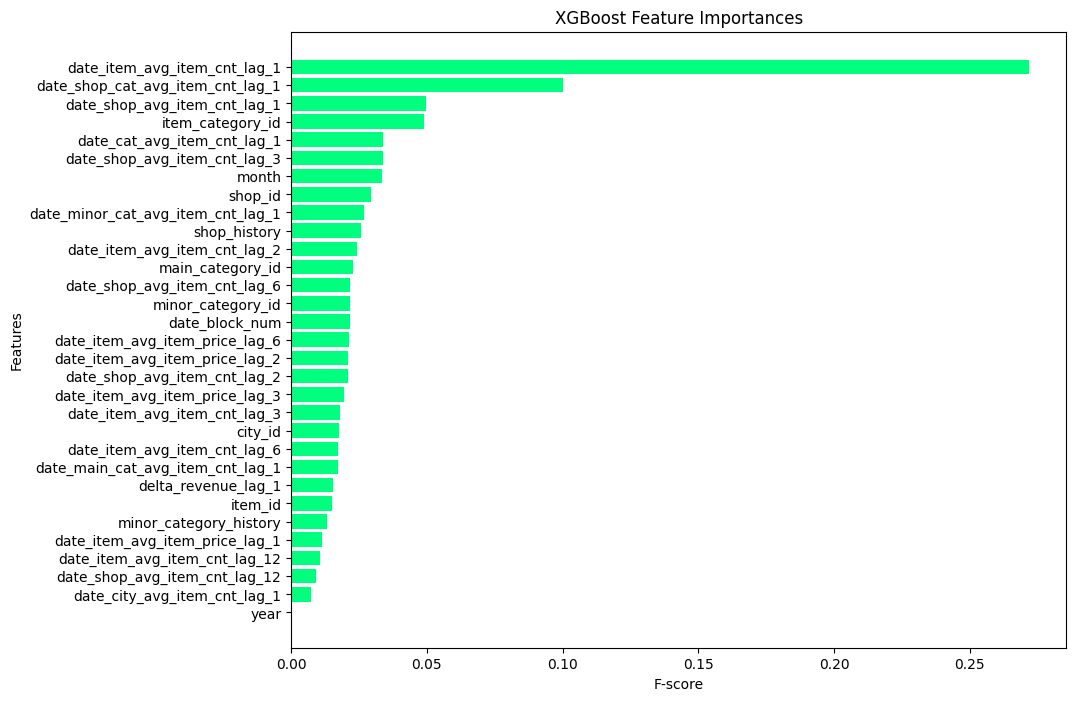

In [23]:
plt.figure(figsize = (10,8))
sorted_idx = model.feature_importances_.argsort()
plt.barh(data.columns[sorted_idx], model.feature_importances_[sorted_idx], color = 'springgreen')
plt.ylabel('Features')
plt.xlabel('F-score')
plt.title('XGBoost Feature Importances')
plt.show()

In [ ]:
k = 3 
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [46]:
def objective(params):

    rmse_scores = []

    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': 'gbtree',
        'eta': params['eta'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'gamma': params['gamma'],
        'min_child_weight': int(params['min_child_weight']),
        'lambda': params['lambda'],
        'alpha': params['alpha']
    }

    for train_idxs, val_idxs in kf.split(X):

        X_train, X_val = X.iloc[train_idxs], X.iloc[val_idxs]
        y_train, y_val = y.iloc[train_idxs], y.iloc[val_idxs]
        

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)

        model = xgb.train(params, dtrain, num_boost_round=500, evals=[(dval, 'eval')], 
                        early_stopping_rounds=10, verbose_eval=False)
        
        y_pred = model.predict(dval)
        
        rmse = root_mean_squared_error(y_val, y_pred)
        rmse_scores.append(rmse)
        
    return {'loss': np.mean(rmse_scores), 'status': STATUS_OK}

In [47]:
space = {
    'eta': hp.uniform('eta', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 5),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'lambda': hp.uniform('lambda', 0, 1),
    'alpha': hp.uniform('alpha', 0, 1),
}

trials = Trials()


best_params = fmin(
    fn=objective,           
    space=space,            
    algo=tpe.suggest,       
    max_evals=50,           
    trials=trials,         
    rstate=np.random.default_rng(42)  
)

print("Best parameters:", best_params)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [52:02<00:00, 62.45s/trial, best loss: 0.3248943285888707]   
Best parameters: {'alpha': np.float64(0.8695404088021474), 'colsample_bytree': np.float64(0.7746855996598426), 'eta': np.float64(0.16130741577801583), 'gamma': np.float64(0.18803536560673795), 'lambda': np.float64(0.594780936860661), 'max_depth': np.float64(10.0), 'min_child_weight': np.float64(6.0), 'subsample': np.float64(0.7470272501348284)}


In [49]:
n = 0
rmse_scores = []

params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': 'gbtree',
        'eta': 0.16,
        'max_depth': 10,
        'subsample': 0.747,
        'colsample_bytree': 0.77,
        'gamma': 0.19,
        'min_child_weight': 6,
        'lambda': 0.595,
        'alpha': 0.87
    }

for train_idxs, val_idxs in kf.split(X):

    X_train, X_val = X.iloc[train_idxs], X.iloc[val_idxs]
    y_train, y_val = y.iloc[train_idxs], y.iloc[val_idxs]
    

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    model = xgb.train(params, dtrain, num_boost_round=500, evals=[(dval, 'eval')], 
                    early_stopping_rounds=10, verbose_eval=False)
    
    y_pred = model.predict(dval)
    
    rmse = root_mean_squared_error(y_val, y_pred)
    rmse_scores.append(rmse)
    print(f'RMSE for split {n+1}: {rmse_scores[n]:.3f}')
    n += 1
print(f'Mean RMSE for all splits: {np.mean(rmse):.3f}')

RMSE for split 1: 0.327
RMSE for split 2: 0.326
RMSE for split 3: 0.324
Mean RMSE for all splits: 0.324
